For a single-qubit pure state $|\psi\rangle=a|0\rangle+b|1\rangle$, this process results in a pure state ensemble of the form $\left\{p(\phi),\left|\psi_\phi\right\rangle\right\}$, where $\left|\psi_\phi\right\rangle=a|0\rangle+b e^{i \phi}|1\rangle$, i.e., the density matrix
$$
\rho^{\prime}=\int d \phi p(\phi)\left|\psi_\phi\right\rangle\left\langle\psi_\phi\right|=\int d \phi p(\phi)\left(\begin{array}{cc}
|a|^2 & a b^* e^{-i \phi} \\
a^* b e^{i \phi} & |b|^2
\end{array}\right)=\left(\begin{array}{cc}
|a|^2 & a b^* g_p \\
a^* b g_p^* & |b|^2
\end{array}\right)
$$
where $g_p=\int d \phi p(\phi) e^{-i \phi}$. Note that the first integral is in the form of a unital CP map: $\rho^{\prime}=$ $\int d \phi K_\phi|\psi\rangle\langle\psi| K_\phi^{\dagger}$, with continuously parametrized Kraus operators $K_\phi=\sqrt{p(\phi)} R(\phi)$, where
$$
R(\phi)=\left(\begin{array}{cc}
1 & 0 \\
0 & e^{i \phi}
\end{array}\right)
$$
in the $\{|0\rangle,|1\rangle\}$ basis.

 In this notebook, we simulate dephasing process using constant phase error for a single qubit by considering several different trajectories where each of the trajectories would have some constant phase choosen randomly. 
 
 This is different from the stochastic dephasing case in a sense that the phases for each of the trajectories can be time-dependent during the time-evolution itself whereas in this case, it remains constant for each of the trajecotories throughout the evolution

In [3]:
# ] activate .

In [4]:
]st

Status `~/Dropbox (Lidar group)/Personal/USC/Rigetti/DD/DD_simulations/Project.toml`
  [f67ccb44] HDF5 v0.17.1
  [b964fa9f] LaTeXStrings v1.3.0
  [2fda8390] LsqFit v0.14.0
  [e429f160] OpenQuantumTools v0.7.5
  [1dea7af3] OrdinaryDiffEq v6.57.0
  [91a5bcdd] Plots v1.39.0
  [d330b81b] PyPlot v2.11.2
  [1fd47b50] QuadGK v2.9.1
  [295af30f] Revise v3.5.6
⌅ [2913bbd2] StatsBase v0.33.21
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [5]:
# import Pkg; Pkg.add("LaTeXStrings")

In [6]:
using StatsBase
using Plots.Measures
using Printf
using LsqFit
using LinearAlgebra
using OpenQuantumTools, OrdinaryDiffEq
using Revise
using QuadGK

E_CHARGE = 1.602176634e-19
PHI_0  = 2.067833831e-15
H_PLANCK = 6.62607015e-34;

In [8]:
v0 = [1.0, 0]
v1 = [0.,1.0]
vp = (v0 + v1)/sqrt(2)
vm = (v0 - v1)/sqrt(2)
vpi = (v0 + 1im*v1)/sqrt(2)
vmi = (v0 - 1im*v1)/sqrt(2)

using Plots
using LaTeXStrings

# calculate the mean and standard deviation of the mean estimator from a sample
function mean_std(sample)
    m, v = mean_and_std(sample, corrected=true)
    m, v/sqrt(length(sample))
end

## Hardware parameters corresponding to transmon qubits

ωq0 = 4.820 ## (in GHz), here it doesn't matter becuase we go into the rotating frame where |+> state is stationary


H_mat = -ωq0*σz/2
tf=600
num_op_trunc = Diagonal([0, 1])
H_mat_trunc = H_mat - H_mat[1,1]*Diagonal([1 for i = 1:2])

ωd = ωq0
H_rotated = H_mat_trunc - ωd * num_op_trunc
real(H_rotated)

2×2 Matrix{Float64}:
  0.0  -0.0
 -0.0   0.0

In [10]:
theta_list = [2*rand() - 1 for i in 1:20]*1e-3
theta_list

20-element Vector{Float64}:
  0.0005563241842868552
  0.00020625311146459024
  0.0006499735329157152
 -0.0005836176827776813
  0.0008326047247426924
 -0.0008298509418362859
  0.0004739062942432506
 -0.0009207217389902946
 -0.0007231427343508292
 -0.0005554499509007023
 -4.652170485473173e-6
 -0.0008722747211082868
  0.0004953778403227147
  0.0006308026056419262
 -0.00028344074829582036
  8.052665062431008e-5
  0.0004886284016506017
 -0.00023654282435067
  0.00021320495074333623
  0.0008150976692586218

## Time-dependent pulses

In [11]:
function pulse(x,σ, x_centre, Ω_val, tg_val)
    σ1_val = tg_val/6
    if x<=(x_centre-3σ) || x>=(x_centre+3σ)
        ans = 0
        else 
        ans=  Ω_val*(exp(-(x-x_centre)^2/2/σ^2)-exp(-tg_val^2/8/σ1_val^2))    ## Here I have used actual tg and and σ1 because
                                                                 ##  their ratio is not affected
    end
    return ans
end


function pulse_center_list(n_pulse)
    return [(2*i-1)/2/n_pulse for i in 1:n_pulse]
end

function build_pulse_funcs(seq, σ_norm, tf_tot, Ω_val, tg_val)
    list0 = [(s)->1]
    list1 = [(s)->pulse(s, σ_norm, pos, Ω_val, tg_val) for pos in seq]
    #list2 = [(s)->drag(s, σ_norm, pos, tf_tot, Ω_val) for pos in seq]
    vcat(list0, list1)#, list2)
end

build_pulse_funcs (generic function with 1 method)

In [12]:
tot_n = 2
a_dagger = Bidiagonal(zeros(Float64,tot_n), [sqrt(i)*(1) for i = 1:tot_n-1], :L)
a = Transpose(a_dagger)
H_x_temp = (a + a_dagger)./2
H_y_temp = 1im*(-a + a_dagger)./2
N_hat = Diagonal([i-1 for i = 1:tot_n])

H_z_temp = (a_dagger*a)-Matrix(I,2,2)/2

axis_error = 0*pi/180
"""Adding errors to the axis of rotation for X and Y gates"""
H_x = cos(axis_error)*H_x_temp + sin(axis_error)*H_y_temp
H_y = cos(axis_error)*H_y_temp - sin(axis_error)*H_x_temp

2×2 Matrix{ComplexF64}:
 0.0+0.0im  -0.0-0.5im
 0.0+0.5im   0.0+0.0im

In [13]:
## -X--X- where - is [tau] free evo. and each of the gates X or Y are 2 tau long i.e. len(X) = len(--)

function cpmg(n_reps, Ω_val, tg_val ,tau_factor, H_rotated)
    tf_tot = n_reps*2*tau_factor*tg_val
    σ_norm = tg_val/6/tf_tot
    
    H_mats = [Complex.(H_rotated)]
    for i in 1:n_reps
        push!(H_mats, H_x)
        push!(H_mats, H_x)
    end

    centers = [(2*i-1)/2/(2*n_reps) for i in 1:(2*n_reps)]
#     println(centers)
    Ham = DenseHamiltonian(build_pulse_funcs(centers, σ_norm,tf_tot, Ω_val, tg_val), H_mats)
    return Ham, tf_tot
end

function XY4(n_reps, Ω_val, tg_val ,tau_factor, H_rotated)
    tf_tot = n_reps*4*tau_factor*tg_val
    σ_norm = tg_val/6/tf_tot
    
    H_mats = [Complex.(H_rotated)]
    for i in 1:n_reps
        push!(H_mats, H_x)
        push!(H_mats, H_y)
        push!(H_mats, H_x)
        push!(H_mats, H_y)
    end

    centers = [(2*i-1)/2/(4*n_reps) for i in 1:(4*n_reps)]
    
    Ham = DenseHamiltonian(build_pulse_funcs(centers, σ_norm,tf_tot, Ω_val, tg_val), H_mats)
    return Ham, tf_tot
end

XY4 (generic function with 1 method)

In [14]:
using QuadGK
tg = 20
deviation = 0
angle_required = pi+deviation*pi/180
Rot_angle = quadgk((x)->2*pi*1*(exp(-(x-tg/2)^2/2/(tg/6)^2)- exp(-tg^2/8/(tg/6)^2)), 0, tg, rtol=1e-8)
Ω = angle_required/Rot_angle[1]

0.06164703846922896

In [15]:
quadgk((x)->2*pi*Ω*(exp(-(x-tg/2)^2/2/(tg/6)^2)- exp(-tg^2/8/(tg/6)^2)), 0, tg, rtol=1e-8)

(3.1415926535897927, 8.501671588945214e-12)

In [22]:
n_seq = 0.5
τ_factor = 15
H_XX,tf_XX = cpmg(2*n_seq, Ω, tg, τ_factor, σz) ## This is temp H
println(tf_XX)

600.0


### Free evol

In [24]:
sol_list = []
tf = tf_XX
v_in = vpi
npoints = 600
for i in 1:20
    H = DenseHamiltonian([(s) -> 1.0], [theta_list[i]*σz], unit=:h)
    annealing = Annealing(H, v_in)#, coupling = coupling)#, bath=fluctuator_ensemble)
    sol = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-8, reltol=1e-8, saveat=range(0,tf,length=npoints));
    push!(sol_list, sol)
end


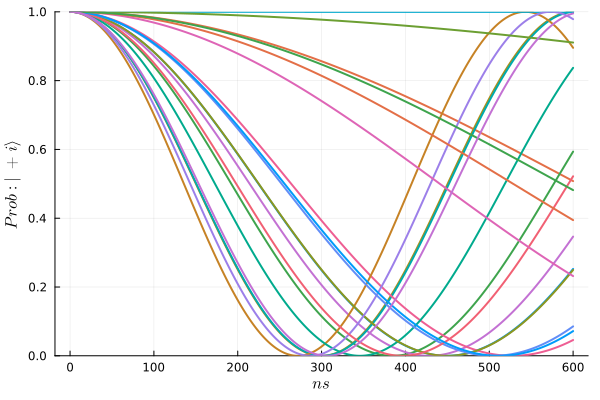

In [26]:
t_axis = range(0,tf,length=npoints)
es_list = []
err_list = []
for (j,tem) in enumerate(theta_list)
    es = []
    err = []
    for (i, s) in enumerate(t_axis)
        sample = [abs2(v_in'*so[i]) for so in sol_list[j]]

        pop, pop_std = mean_std(sample)
        push!(es, pop)
        push!(err, 2*pop_std)
        
    end
    push!(es_list, es)
    push!(err_list, err)
end
# i = 1
plot(t_axis, es_list,  linewidth=2, label="")
xlabel!(L"ns")
ylabel!(L"Prob: |+i\rangle")
ylims!(0,1)

In [27]:
rho_all_traj_list = []
pop_all_traj_list = []
traj1 = nothing
rho_sample = nothing
for (j,traj) in enumerate(sol_list)
    traj1 = traj
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list, rho_sample_list)
    push!(pop_all_traj_list, sample_pop_list)
end

## With time-dependent DD

## XX

In [28]:
sol_list_XX = []
v_in = vpi
tf = tf_XX

for i in 1:20
    H_XX,tf_XX = cpmg(2*n_seq, Ω, tg, τ_factor, theta_list[i]*σz)
    tf = tf_XX
    annealing = Annealing(H_XX, v_in)
    sol = solve_schrodinger(annealing, tf, alg=Tsit5(), abstol=1e-8, reltol=1e-8, tstops=range(0,tf,length=2*npoints),saveat=range(0,tf,length=npoints));
    push!(sol_list_XX, sol)
end

In [29]:
tf_XX

600.0

In [31]:
t_axis = range(0,tf,length=npoints)
es_list_XX = []
err_list_XX = []
for (j,tem) in enumerate(theta_list)
    es = []
    err = []
    for (i, s) in enumerate(t_axis)
        sample = [abs2(v_in'*so[i]) for so in sol_list_XX[j]]

        pop, pop_std = mean_std(sample)
        push!(es, pop)
        push!(err, 2*pop_std)
        
    end
    push!(es_list_XX, es)
    push!(err_list_XX, err)
end

In [32]:
τ_factor, n_reps

(15, 2)

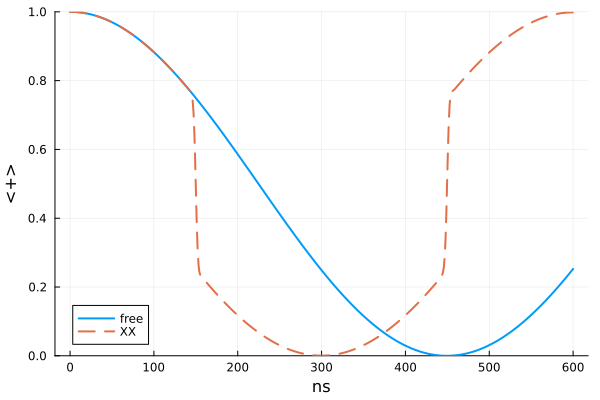

In [35]:
i  = 1
plot(t_axis, es_list[i],  ls=:solid,linewidth=2, label="free")
plot!(t_axis, es_list_XX[i],  ls=:dash, linewidth=2, label="XX")

xlabel!("ns")
ylabel!("<+>")
ylims!(0,1)

In [36]:
rho_all_traj_list_XX = []
pop_all_traj_list_XX = []
traj1 = nothing
rho_sample = nothing
for (j,traj) in enumerate(sol_list_XX)
    traj1 = traj
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list_XX, rho_sample_list)
    push!(pop_all_traj_list_XX, sample_pop_list)
end

using HDF5

function save_vector_to_group(file, vector_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(vector_data)
        matrix_data = hcat(vector_data[i]...)
        write(g, "dataset_$i", matrix_data)
    end
end

function save_list_to_group(file, list_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(list_data)
        write(g, "dataset_$i", list_data[i])
    end
end

h5open("./data/rho_init_plus_i_DD_time_dependent_XX_under_fixed_phases.h5", "w") do file
    save_vector_to_group(file, rho_all_traj_list, "free")
    save_vector_to_group(file, rho_all_traj_list_XX, "XX")
    save_list_to_group(file, collect(t_axis), "time")
end